In [91]:
import pandas as pd
from glob import glob
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model import LinearRegression, Ridge
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [93]:
def wrangle(filepath):
    # 1.
    # Read CSV file.
    df = pd.read_csv(filepath,sep=';', encoding='latin-1')

    # Subset data: Apartments in "Distrito Federal", less than 100,000 .
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    # 2.
    # Subset data: Remove outliers for "surface_covered_in_m2".
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    # 3.
    # Split "lat-lon" column .
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    # 4.
    # Create a "borough" feature .
    df["borough"]=df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    # 5.
    # Drop columns that are more than 50% null values.
    df.drop(columns=['surface_total_in_m2','price_usd_per_m2','floor','rooms','expenses'],
            inplace=True)
    # 6.
    # Drop columns containing low- or high-cardinality categorical values.
    df.drop(columns=['operation','property_type','currency',"properati_url"],
            inplace=True)
    # 7.
    # Drop any columns that would constitute leakage for the target "price_aprox_usd".
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2'],
            inplace=True)
    return df

In [96]:
# import data
files=glob('data/mexico-city-real-estate-*.csv')
frames=[wrangle(file) for file in files]
df = pd.concat(frames,ignore_index=True)
df.drop(columns = ["Unnamed: 0"],inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Ju?rez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Ju?rez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoac?n


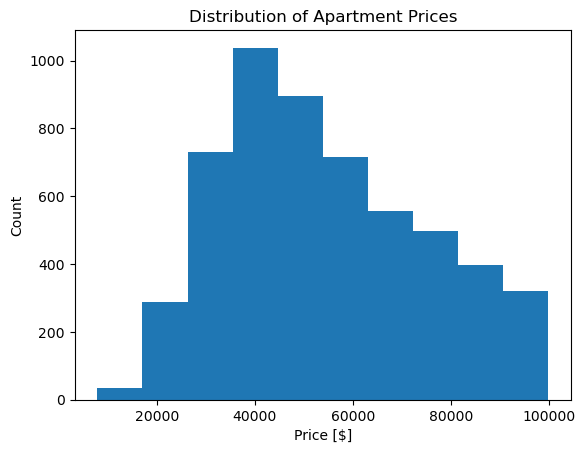

In [98]:
# Explore data
plt.hist(df["price_aprox_usd"])
plt.xlabel("Price [$]")
plt.ylabel("Count")
plt.title ("Distribution of Apartment Prices");

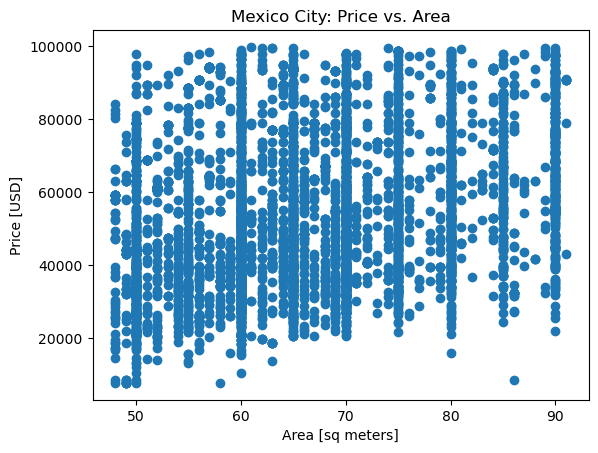

In [102]:
# scatter plot that apartment price
plt.scatter(x=df["surface_covered_in_m2"],y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title('Mexico City: Price vs. Area');

In [103]:
# Mapbox scatter plot that shows the location of the apartments and their price.
fig = px.scatter_mapbox(
    df,  
    lat='lat',
    lon='lon',
    width=600, 
    height=600, 
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"], 
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [104]:
# Split
X_train = df.drop(columns="price_aprox_usd")
y_train = df["price_aprox_usd"]
y_train

0       94022.66
1       70880.12
2       68228.99
3       24235.78
4       94140.20
          ...   
5468    89178.35
5469    37758.66
5470    36839.97
5471    85352.10
5472    64979.97
Name: price_aprox_usd, Length: 5473, dtype: float64

In [105]:
# Build Model
# Baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae =mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [106]:
# Iterate
model =make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [122]:
#Evaluate
X_test =pd.read_csv('data/mexico-city-test-features.csv',sep=';', encoding='latin-1')
X_test.drop(columns = ["Unnamed: 0"],inplace=True)
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoac?n
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Ju?rez


In [109]:
# test
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [110]:
# features and features
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients,index=features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Ju?rez             13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_Coyoac?n                   3737.561001
borough_?lvaro Obreg?n             3275.121061
borough_Iztapalapa               -13349.017448
borough_Cuauhtémoc                 -350.531990
borough_Tl?huac                  -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429804
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

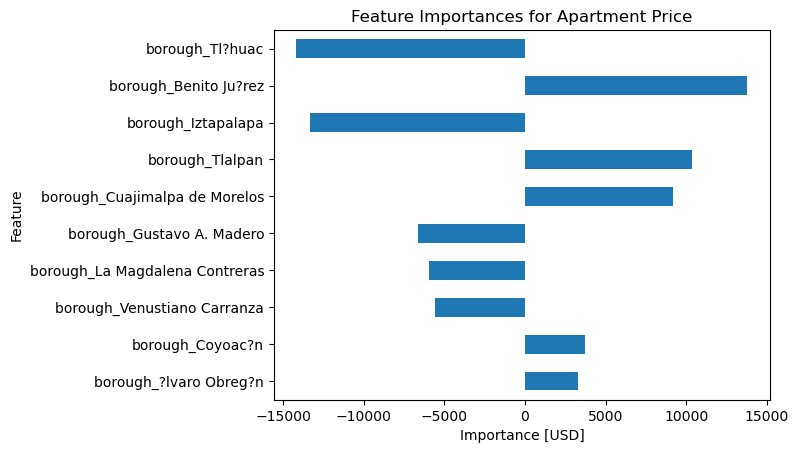

In [111]:
# horizontal bar chart that shows the 10 most influential coefficients
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price")

In [123]:
# get prediction
X_test = pd.read_csv("data/buenos-aires-test-features.csv",sep=';', encoding='latin-1')
X_test.rename(columns = {'neighborhood':'borough'}, inplace = True)
X_test.head()
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0   -80416.797523
1   -77799.973712
2   -84155.447553
3   -84029.627492
4   -81672.928170
dtype: float64